In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq
import urllib
import requests
import shutil

# Deutsche Emissionen

In [2]:
# source information https://www.umweltbundesamt.de/indikator-emission-von-treibhausgasen
url = "https://www.umweltbundesamt.de/sites/default/files/medien/384/bilder/dateien/1-3_dzu_thg-emissionen_1.xlsx"
file_german_co2_emissions = "german_co2_emissions.xlsx"
urllib.request.urlretrieve(url, file_german_co2_emissions)

('german_co2_emissions.xlsx', <http.client.HTTPMessage at 0x1204d9668>)

In [3]:
df_comp = pd.read_excel(file_german_co2_emissions,
                        sheet_name='1-3_2_Abb_Daten',
                        header=8,
                        index_col=0,
                        usecols="B:M"
)
data_years = np.arange(1990, 2020)

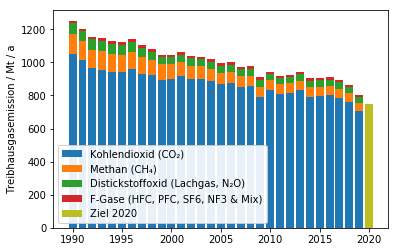

In [4]:
components = df_comp.iloc[:,1:5].dropna()
y_offset = np.zeros(len(components))
for key_i in components.keys():
    plt.bar(data_years, components[key_i], bottom=y_offset, label=key_i)
    y_offset += components[key_i]
plt.ylabel('Treibhausgasemission / Mt / a')
plt.bar(2020, df_comp.at[2020,'Ziel 2020'], label='Ziel 2020', color='tab:olive')
plt.legend(framealpha=.9)
plt.savefig('thg_deutschland_componenten.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

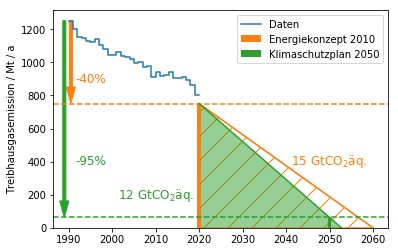

In [5]:
german_emissions = df_comp['THG Gesamt'].dropna().values
plt.plot(np.arange(1990, 2021),
         np.r_[german_emissions[0], german_emissions],
         drawstyle='steps',
         label='Daten')

# 2020 is 40% reduction compared to 1990 as said in "Energiekonzept 2010 (BMWi)"
# future_years = [2020, 2030, 2040]
# future_goals = [df_comp.at[year_i, 'Ziel 2020'] for year_i in future_years]
# plt.bar(future_years, future_goals, label='Ziel')
energiekonzept_years = [2020, 2060]
reference_1990 = df_comp.at[1990,'THG Gesamt']
target_emissions = np.poly1d(np.polyfit(energiekonzept_years,
                                        [reference_1990*0.6, 0],
                                        1))(energiekonzept_years)
plt.axhline(reference_1990*0.6, ls='--', color='tab:orange',
#             label='Reduktion um 40%'
           )
plt.plot(energiekonzept_years,
         target_emissions,
#          label='Energiekonzept 2010',
         color='tab:orange'
        )
plt.bar([2020],
        reference_1990*0.6,
        label='Energiekonzept 2010',
        color='tab:orange'
       )
# 2050 is 95% reduction compared to 1990 as said in "Klimaschutzplan 2050 (BMU)"
plt.axhline(reference_1990*0.05, ls='--', color='tab:green',
#             label='Reduktion um 95%'
           )
plt.bar([2050],
        reference_1990*0.05,
        label='Klimaschutzplan 2050',
        color='tab:green'
       )
func_klimaschutzplan = np.poly1d(np.polyfit([2020, 2050], [reference_1990*0.6, reference_1990*0.05], 1))
zero_emission_year_klimaschutzplan = brentq(func_klimaschutzplan, 2020, 2100)
target2_emissions = func_klimaschutzplan([2020, zero_emission_year_klimaschutzplan])
plt.plot([2020, zero_emission_year_klimaschutzplan],
          target2_emissions,
          color='tab:green')

plt.fill_between(energiekonzept_years,
                 target_emissions,
                 facecolor='',
                 edgecolor='tab:orange',
                 hatch='/',
                )
plt.fill_between([2020, zero_emission_year_klimaschutzplan],
                 target2_emissions,
                 alpha=0.5,
                 facecolor='tab:green',
                )
plt.arrow(1990.5, reference_1990, 0, -reference_1990*0.4,
          width=0.7,
          head_length=100,
          length_includes_head=True,
          color='tab:orange')
plt.arrow(1989, reference_1990, 0, -reference_1990*0.95,
          width=.7,
          head_length=100,
          length_includes_head=True,
          color='tab:green')
plt.text(1995, 900, '-40%', ha='center', va='center', color='tab:orange', fontsize='large')
plt.text(1995, 400, '-95%', ha='center', va='center', color='tab:green', fontsize='large')
remaining_co2_emissions_energiekonzept = (reference_1990*0.6)*(2060-2020)/2/1e3
plt.text(2050, 400,
         '{:.0f} GtCO$_2$äq.'.format(remaining_co2_emissions_energiekonzept),
         ha='center', va='center', fontsize='large', color='tab:orange'
        )
remaining_co2_emissions_klimaschutzplan = (reference_1990*0.6)*(zero_emission_year_klimaschutzplan-2020)/2/1e3
plt.text(2010, 200,
         '{:.0f} GtCO$_2$äq.'.format(remaining_co2_emissions_klimaschutzplan),
         ha='center', va='center', fontsize='large', color='tab:green'
        )
plt.ylabel('Treibhausgasemission / Mt / a')
plt.legend()
plt.ylim(bottom=0)
plt.savefig('thg_deutschland_ziele.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [6]:
df_sectors = pd.read_excel(file_german_co2_emissions,
                           sheet_name='KLIM-01_Abb-Daten',
                           header=12,
                           usecols="C:J"
).dropna()

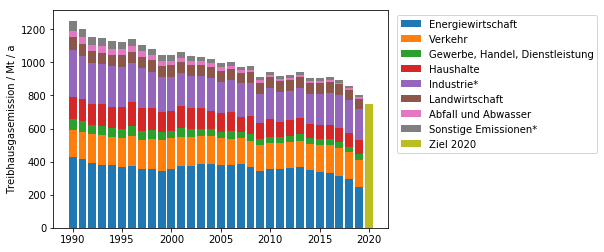

In [7]:
y_offset = np.zeros(len(data_years))
for key_i in df_sectors.keys():
    plt.bar(data_years, df_sectors[key_i], bottom=y_offset, label=key_i)
    y_offset += df_sectors[key_i]

plt.bar(2020, df_comp.at[2020,'Ziel 2020'], label='Ziel 2020')

plt.ylabel('Treibhausgasemission / Mt / a')
plt.legend(bbox_to_anchor=(1.01, 1.))
plt.savefig('thg_deutschland_sectoren.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [8]:
def plot_stacked_emissions(df, ylabel):
    y_offset = np.zeros(len(df))
    for key_i in df.keys():
        plt.bar(df.index, df[key_i], bottom=y_offset, label=key_i)
        y_offset += df[key_i]
    plt.ylabel(ylabel)
    plt.title('Emissionsverursacher in Deutschland'.format(ylabel))
    plt.legend(bbox_to_anchor=(1.01, 1.))
    plt.show()

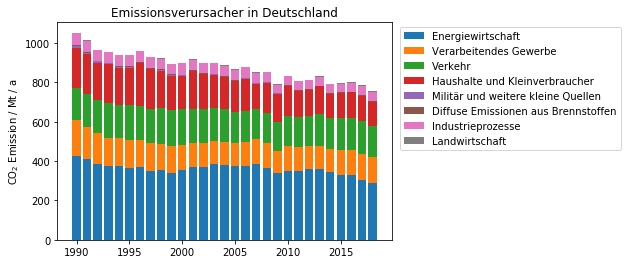

In [9]:
df_co2 = pd.read_excel(file_german_co2_emissions,
                       sheet_name='1-3-1_4-Abb_Daten',
                       header=8,
                       index_col=0,
                       usecols="B:J"
)
plot_stacked_emissions(df_co2, 'CO$_2$ Emission / Mt / a')

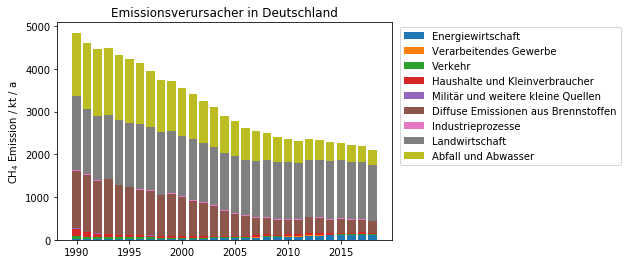

In [10]:
df_ch4 = pd.read_excel(file_german_co2_emissions,
                       sheet_name='1-3-3_2-Abb_Daten',
                       header=8,
                       index_col=0,
                       usecols="B:K"
)
plot_stacked_emissions(df_ch4, 'CH$_4$ Emission / kt / a')

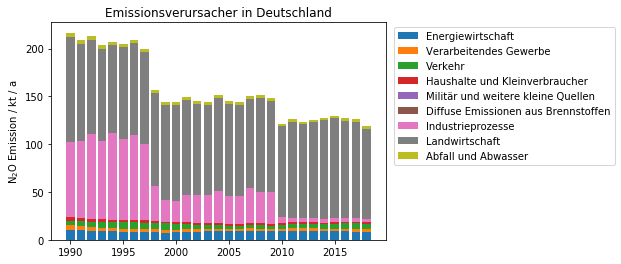

In [11]:
df_n2o = pd.read_excel(file_german_co2_emissions,
                       sheet_name='1-3-2_2-Abb_Daten',
                       header=8,
                       index_col=0,
                       usecols="B:K"
)
plot_stacked_emissions(df_n2o, 'N$_2$O Emission / kt / a')

# Weltweiter Temperaturanstieg

In [12]:
# HadCRUT4 data see
# https://crudata.uea.ac.uk/cru/data/temperature/
# https://www.metoffice.gov.uk/hadobs/hadcrut4/
url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg.txt"
file_hadcrut4 = "hadcrut4_data_annual_average.txt"
r = requests.get(url)
with open(file_hadcrut4, 'wb') as outfile:
    outfile.write(r.content)

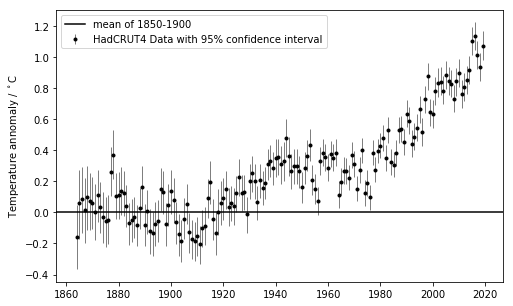

In [13]:
hadcrut_data = np.genfromtxt(file_hadcrut4, skip_header=14)[:-1].T

years = hadcrut_data[0]
temp_median = hadcrut_data[1]
temp_low = hadcrut_data[10]
temp_up = hadcrut_data[11]
temp_mean_1850_1900 = np.mean(temp_median[:50])

plt.figure(figsize=(8,5))
plt.errorbar(years,
             temp_median - temp_mean_1850_1900,
             yerr=(temp_median - temp_low, temp_up - temp_median),
             ls='',
             marker='.',
             c='k',
             elinewidth=0.5,
             label='HadCRUT4 Data with 95% confidence interval'
            )
plt.axhline(0, c='k', label='mean of 1850-1900')
plt.ylabel('Temperature annomaly / $^\circ$C')
# plt.xlabel('Year')
plt.legend(loc='upper left')
plt.savefig('temperatur_annomaly_hadcrut.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

# Treibhausgas Konzentration

In [20]:
# Data from IPCC AR5 
url = "https://www.ipcc.ch/site/assets/uploads/2017/09/WG1AR5_AIISM_Datafiles.xlsx"
file_global_ghg_emissions = "global_ghg_emissions.xlsx"
r = requests.get(url)
with open(file_global_ghg_emissions, 'wb') as outfile:
    outfile.write(r.content)

In [21]:
# Data of recent years from National Oceanic Atmospheric Administration
# https://www.esrl.noaa.gov/gmd/ccgg/trends/
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_annmean_gl.txt"
file_concentration_co2 = "concentration_co2_annual.txt"
with urllib.request.urlopen(url) as r:
    with open(file_concentration_co2, 'wb') as f:
        shutil.copyfileobj(r, f)
url = "ftp://aftp.cmdl.noaa.gov/products/trends/ch4/ch4_annmean_gl.txt"
file_concentration_ch4 = "concentration_ch4_annual.txt"
with urllib.request.urlopen(url) as r:
    with open(file_concentration_ch4, 'wb') as f:
        shutil.copyfileobj(r, f)
url = "ftp://aftp.cmdl.noaa.gov/products/trends/n2o/n2o_annmean_gl.txt"
file_concentration_n2o = "concentration_n2o_annual.txt"
with urllib.request.urlopen(url) as r:
    with open(file_concentration_n2o, 'wb') as f:
        shutil.copyfileobj(r, f)

In [22]:
df_concentration = pd.read_excel(file_global_ghg_emissions,
                                 sheet_name='AII-1-1a',
                                 header=7,
                                 usecols="A:D",
                                 nrows=98,
)
co2_year, co2_annual_mean, co2_unc = np.genfromtxt(file_concentration_co2).T
ch4_year, ch4_annual_mean, ch4_unc = np.genfromtxt(file_concentration_ch4).T
n2o_year, n2o_annual_mean, n2o_unc = np.genfromtxt(file_concentration_n2o).T

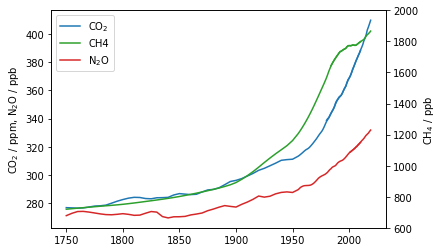

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
color = 'tab:blue'
lns1 = ax1.plot(df_concentration[1:]['Year'], 
         df_concentration[1:]['CO2 (ppm)'],
         color=color,
         label='CO$_2$')
ax1.plot(co2_year,
         co2_annual_mean,
         color=color)
ax1.set_ylabel('CO$_2$ / ppm, N$_2$O / ppb')#, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
lns3 = ax1.plot(df_concentration[1:]['Year'],
         df_concentration[1:]['N2O (ppb)'],
         label='N$_2$O',
        color=color)
ax1.plot(n2o_year,
         n2o_annual_mean,
         color=color)


color = 'tab:green'
ax2 = ax1.twinx()
lns2 = ax2.plot(df_concentration[1:]['Year'],
         df_concentration[1:]['CH4 (ppb)'],
         color=color,
         label='CH4')
ax2.plot(ch4_year,
         ch4_annual_mean,
         color=color)
ax2.set_ylabel('CH$_4$ / ppb')#, color=color)
# ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=600,top=2000)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.show()

# CO$_2$ Emission

In [24]:
# Integrated Carbon Observation System - Global Crbon Project 2019
# article: doi.org/10.5194/essd-11-1783-2019
# data: doi.org/10.18160/gcp-2019
url = 'https://data.icos-cp.eu/licence_accept?ids=["Z6S-dJJHB4RCe07mcmhMYxwx"]'
file_global_co2_emissions = "global_co2_emissions.xlsx"
r = requests.get(url)
with open(file_global_co2_emissions, 'wb') as outfile:
    outfile.write(r.content)

In [25]:
df_co2_history = pd.read_excel(file_global_co2_emissions,
                               sheet_name='Historical Budget',
                               header=14,
                               usecols="A:G",
)
# values in (GtC/yr)
# to calculate in GtCO2/yr one has to multiply by (1+2*15.999/12.011=3.66)
convert_GtC_to_GtCO2 = 1+2*15.999/12.011

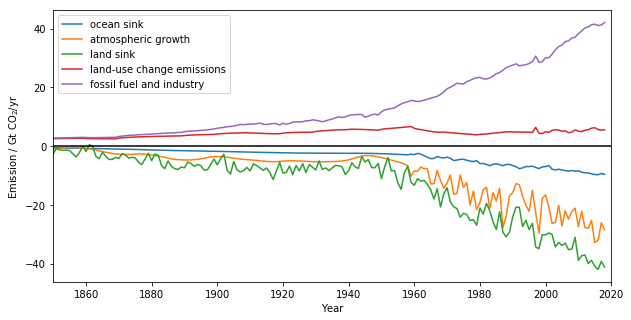

In [26]:
positiv_emission = df_co2_history.keys()[[2,1]]
negativ_emission = df_co2_history.keys()[[4,3,5]]

plt.figure(figsize=(10,5))

y_offset = np.zeros(len(df_co2_history['Year']))
for comp_i in negativ_emission:
    plt.plot(df_co2_history['Year'], (y_offset - df_co2_history[comp_i])*convert_GtC_to_GtCO2, label=comp_i)
    y_offset -= df_co2_history[comp_i]

y_offset = np.zeros(len(df_co2_history['Year']))
for comp_i in positiv_emission:
    plt.plot(df_co2_history['Year'], (y_offset + df_co2_history[comp_i])*convert_GtC_to_GtCO2, label=comp_i)
    y_offset += df_co2_history[comp_i]

plt.axhline(0, c='k')
plt.xlim(1850,2020)
plt.xlabel('Year')
plt.ylabel('Emission / Gt CO$_2$/yr')
plt.legend()
plt.show()

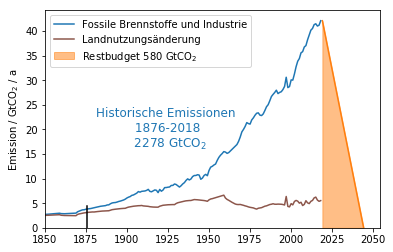

In [27]:
co2_restbudget = np.array([420, 580, 840])
combined_emission_pos = (df_co2_history['fossil fuel and industry'] + df_co2_history['land-use change emissions'].fillna(0))*convert_GtC_to_GtCO2

final_year = (co2_restbudget-combined_emission_pos.iloc[-1])*2/combined_emission_pos.iloc[-2]+2018
plt.plot([df_co2_history['Year'].iloc[-1]+1, final_year[1]],
         [combined_emission_pos.iloc[-1], 0],
         color='tab:orange'
        )
plt.fill_between([df_co2_history['Year'].iloc[-1]+1, final_year[1]],
                 [combined_emission_pos.iloc[-1], 0],
                 alpha=0.5,
                 facecolor='tab:orange',
                 edgecolor='tab:orange',
                 label='Restbudget {} GtCO$_2$'.format(co2_restbudget[1])
                )
plt.text(1925, 20,
         'Historische Emissionen \n 1876-2018 \n {:.0f} GtCO$_2$'.format(sum(combined_emission_pos.iloc[126:])),
         ha='center', va='center', fontsize='large',
         color='tab:blue'
        )


y_offset = df_co2_history['land-use change emissions']
plt.plot(df_co2_history['Year'],
         (y_offset + df_co2_history['fossil fuel and industry'])*convert_GtC_to_GtCO2,
         label='Fossile Brennstoffe und Industrie',
         color='tab:blue'
        )
plt.plot(df_co2_history['Year'],
         df_co2_history['land-use change emissions']*convert_GtC_to_GtCO2,
         label='Landnutzungsänderung',
         color='tab:brown'
        )


plt.ylabel('Emission / GtCO$_2$ / a')
plt.xlim(left=1850)
plt.ylim(bottom=0)
plt.legend()
plt.axvline(1876, ymax=.1, color='k')
plt.savefig('co2_restbudget_simple.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [28]:
# article: doi.org/10.5194/essd-11-1783-2019
# data: doi.org/10.18160/gcp-2019
url = 'https://data.icos-cp.eu/licence_accept?ids=["7yV2z2CffZT8d65qndeQZztL"]'
file_global_co2_emissions_nations = "global_co2_emissions_nations.xlsx"
r = requests.get(url)
with open(file_global_co2_emissions_nations, 'wb') as outfile:
    outfile.write(r.content)

In [29]:
df_countries = pd.read_excel(file_global_co2_emissions_nations,
                             sheet_name='Territorial Emissions',
                             header=16,
                             index_col=0,
)
# values in (GtC/yr)
# to calculate in GtCO2/yr one has to multiply by (1+2*15.999/12.011=3.66)
convert_GtC_to_GtCO2 = 1+2*15.999/12.011

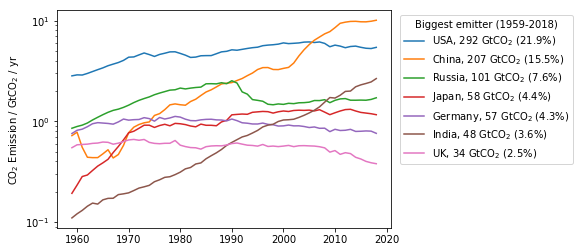

In [30]:
country_labels = ['USA', 'China', 'Russia', 'Japan', 'Germany', 'India', 'UK']
country_labels_co2 = [
    'USA',
    'China',
    'Russian Federation',
    'Japan',
    'Germany',
    'India',
    'United Kingdom',
]
all_sums = df_countries.sum(axis=0)
for idx, key_i in enumerate(country_labels_co2):
    plt.plot(df_countries.index, df_countries[key_i]*convert_GtC_to_GtCO2/1e3,
             label='{}, {:.0f} GtCO$_2$ ({:.1f}$\%$)'.format(
                 country_labels[idx], all_sums[key_i]*convert_GtC_to_GtCO2/1e3, all_sums[key_i]/all_sums['World']*100))
plt.yscale('log')
# plt.xlabel('Year')
plt.ylabel('CO$_2$ Emission / GtCO$_2$ / yr')
plt.legend(bbox_to_anchor=(1.01, 1.), title='Biggest emitter (1959-2018)')
plt.savefig('carbon_emission_countries.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [31]:
# data from UN Department of Economic and Social Affairs Population Dynamics - World Population Prospects 2019
# https://population.un.org/wpp/
url = "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx"
file_world_population = "world_population.xlsx"
r = requests.get(url)
with open(file_world_population, 'wb') as outfile:
    outfile.write(r.content)

In [32]:
df_pop = pd.read_excel(file_world_population,
                       sheet_name='ESTIMATES',
                       header=16,
                       index_col=2,
)

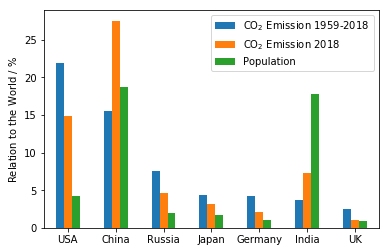

In [33]:
country_labels_pop = [
 'United States of America',
 'China',
 'Russian Federation',
 'Japan',
 'Germany',
 'India',
 'United Kingdom',
]
co2_hist = np.empty(7)
co2_18 = np.empty(7)
pop_18 = np.empty(7)
for idx in range(7):
    co2_hist[idx] = all_sums[country_labels_co2[idx]]/all_sums['World']*100
    co2_18[idx] = df_countries.at[2018,country_labels_co2[idx]] / df_countries.at[2018, 'World']*100
    pop_18[idx] = df_pop.at[country_labels_pop[idx],'2018'] / df_pop.at['WORLD', '2018']*100

groups = np.array([co2_hist, co2_18, pop_18])
pd.DataFrame(groups, 
             columns=country_labels,
             index=['CO$_2$ Emission 1959-2018', 'CO$_2$ Emission 2018', 'Population'],
            ).T.plot.bar()
plt.ylabel('Relation to the World / $\%$')
plt.xticks(rotation=0)
plt.savefig('carbon_countries_compare.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [34]:
print("Restbudget from 2018")
print('World: ', co2_restbudget[1])
print("Germany: ", (df_pop.at['Germany','2018'] / df_pop.at['WORLD', '2018']) * co2_restbudget[1])

Restbudget from 2018
World:  580
Germany:  6.3178592453008235


In [35]:
print("Average emission per person")
print("World", convert_GtC_to_GtCO2*1e3* df_countries.at[2018,'World']/df_pop.at['WORLD', '2018'])
print("Germany", convert_GtC_to_GtCO2*1e3* df_countries.at[2018,'Germany']/df_pop.at['Germany','2018'])

Average emission per person
World 4.792674086041062
Germany 9.131059362632886


In [36]:
print("these are just the CO$_2$ emissions, without other GHG")
print("German GHG emission from Umweltamt", df_comp.at[2018,'THG Gesamt'])
print("German CO$_2$ emission from Umweltamt", df_comp.at[2018,df_comp.keys()[1]])
print("German emission from Global Carbon Project", df_countries.at[2018,'Germany']*convert_GtC_to_GtCO2)

these are just the CO$_2$ emissions, without other GHG
German GHG emission from Umweltamt 864.242351154969
German CO$_2$ emission from Umweltamt 759.9861646169237
German emission from Global Carbon Project 759.0139495870127


# World Map with flights

In [37]:
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

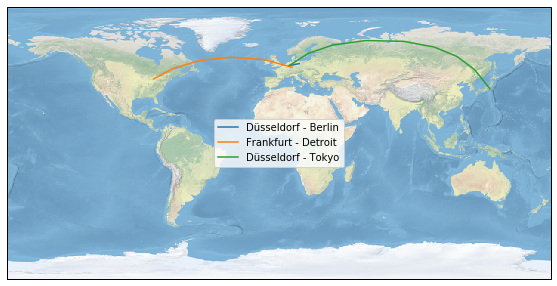

In [38]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# date = datetime.datetime(1999, 12, 31, 12)
coord_ber = [13.404954, 52.520008]
coord_dus = [6.77616, 51.22172]
coord_fra = [8.682127, 50.110924]
coord_det = [-83.045753, 42.331429]
coord_tokyo = [139.839478, 35.652832]
ax.stock_img()

def plot_coord_help(depart, arrive, label=None):
    ax.plot([depart[0], arrive[0]], [depart[1], arrive[1]], transform=ccrs.Geodetic(), label=label)
plot_coord_help(coord_dus, coord_ber, 'Düsseldorf - Berlin')
plot_coord_help(coord_fra, coord_det, 'Frankfurt - Detroit')
plot_coord_help(coord_dus, coord_tokyo, 'Düsseldorf - Tokyo')

ax.legend(loc='center')
fig.savefig('flights_2019.pdf', bbox_inches='tight', pad_inches=0.00)
plt.show()